In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Load Data

In [15]:
food_orders = pd.read_csv('food_orders_new_delhi.csv')
food_orders.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [16]:
food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


- No missing columns in any column
- Data cleaning:
    + Convert "Order Date and Time" and "Delivery Data and Time" to datetime format
    + Convert "Discounts and Offers" to numeric value (calculate discount amounts)

# Clean Data

In [17]:
# Convert date and time columns to datetime format
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

In [18]:
# Helper function to extract numeric values from 'Discounts and Offers'
# 2 types of discounts: exact amount off from total or percentage off
def extract_discount(input):
    if not isinstance(input, str):
        return ('none', 0.0)
    if 'off' in input:
        discount = float(input.split(' ')[0])
        return ('fixed', discount)
    elif '%' in input:
        discount = float(input.split('%')[0])
        return ('percentage', discount)
    return ('none', 0.0)

# Extract discount type and value
food_orders[['Discount Type', 'Discount Value']] = food_orders['Discounts and Offers'].apply(
    lambda x: pd.Series(extract_discount(x))
)


In [24]:
# Calculate discount amount
def calculate_discount_amount(row):
    if row['Discount Type'] == 'percentage':
        return row['Order Value'] * row['Discount Value'] / 100
    elif row['Discount Type'] == 'fixed':
        return row['Discount Value']
    return 0.0
food_orders['Discount Amount'] = food_orders.apply(calculate_discount_amount, axis = 1)
food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order ID                1000 non-null   int64         
 1   Customer ID             1000 non-null   object        
 2   Restaurant ID           1000 non-null   object        
 3   Order Date and Time     1000 non-null   datetime64[ns]
 4   Delivery Date and Time  1000 non-null   datetime64[ns]
 5   Order Value             1000 non-null   int64         
 6   Delivery Fee            1000 non-null   int64         
 7   Payment Method          1000 non-null   object        
 8   Discounts and Offers    815 non-null    object        
 9   Commission Fee          1000 non-null   int64         
 10  Payment Processing Fee  1000 non-null   int64         
 11  Refunds/Chargebacks     1000 non-null   int64         
 12  Discount Type           1000 non-null   object   

# Cost and Profitability Analysis

In [ ]:
#  Calculate total costs, revenue and profit for the platform
food_orders['Total Costs'] = (food_orders['Payment Processing Fee'] 
                              + food_orders['Discount Amount']
                              + food_orders['Refunds/Chargebacks'])
food_orders['Revenue'] = food_orders['Commission Fee'] + food_orders['Delivery Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

In [28]:
# Aggregate data to get overall metrics 
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}
print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 155610, 'Total Costs': 132421.85, 'Total Profit': 23188.15}


# Visualization

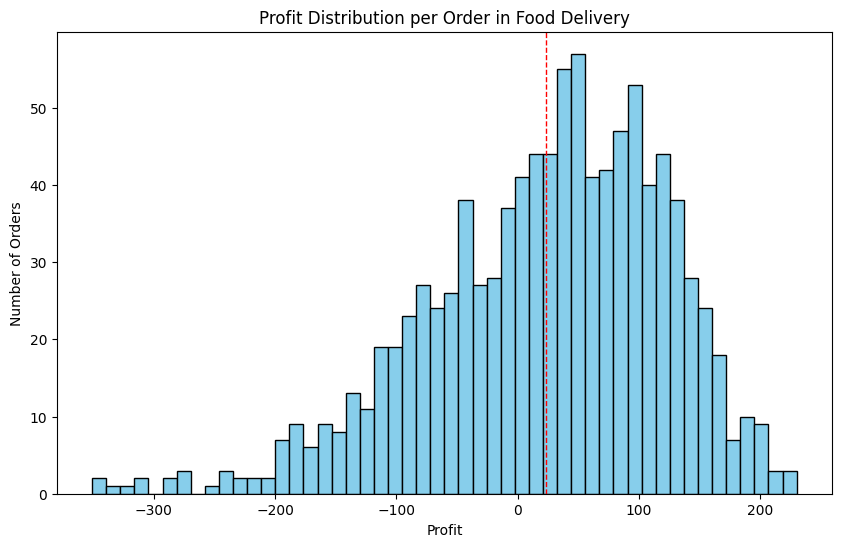

In [30]:
# Profit Distribution Per Order

plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()